In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

# from matplotlib import rcParam
import seaborn as sb
import os
import sys

sys.setrecursionlimit(1000000)
from scipy.stats import spearmanr
from scipy.spatial.distance import cdist
import pathlib
import scipy as sp
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

mcc = MouseConnectivityCache()
from scipy.stats import pearsonr
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import scanpy as sc
import anndata as ad
from preprocessing_sequencing import preprocess_sequences as ps
from decimal import Decimal

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/camp/home/turnerb/.conda/envs/MAPseq_proces

In [3]:
# load datasets
FIAA456a = pd.read_pickle(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/Sequencing/barcode_matrix_normalised.pkl"
)
FIAA456d = pd.read_pickle(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6d/Sequencing/barcode_matrix_normalised.pkl"
)

In [2]:
FIAA456a_parameters = ps.load_parameters(
    directory="/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/Sequencing"
)
FIAA456d_parameters = ps.load_parameters(
    directory="/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6d/Sequencing"
)

In [5]:
# what does the distribution max/2nd max look like?
filtered_barcodes_FIAA456a = pd.DataFrame()
filtered_barcodes_FIAA456d = pd.DataFrame()
filtered_barcodes_FIAA456a["highest"] = FIAA456a.max(axis=1) + 1
filtered_barcodes_FIAA456d["highest"] = FIAA456d.max(axis=1) + 1
filtered_barcodes_FIAA456a["second"] = (
    FIAA456a.apply(lambda row: row.nlargest(2).values[-1], axis=1) + 1
)
filtered_barcodes_FIAA456d["second"] = (
    FIAA456d.apply(lambda row: row.nlargest(2).values[-1], axis=1) + 1
)
filtered_barcodes_FIAA456a["relative_to_max"] = np.log10(
    filtered_barcodes_FIAA456a["highest"] / filtered_barcodes_FIAA456a["second"]
)
filtered_barcodes_FIAA456d["relative_to_max"] = np.log10(
    filtered_barcodes_FIAA456d["highest"] / filtered_barcodes_FIAA456d["second"]
)

In [6]:
plt.hist(
    filtered_barcodes_FIAA456a["relative_to_max"],
    bins=150,
    alpha=0.5,
    color="Black",
    label="FIAA45.6a",
    weights=np.zeros_like(filtered_barcodes_FIAA456a["relative_to_max"])
    + 1.0 / filtered_barcodes_FIAA456a["relative_to_max"].size,
)

plt.hist(
    filtered_barcodes_FIAA456d["relative_to_max"],
    bins=150,
    alpha=0.5,
    label="FIAA45.6d",
    weights=np.zeros_like(filtered_barcodes_FIAA456d["relative_to_max"])
    + 1.0 / filtered_barcodes_FIAA456d["relative_to_max"].size,
)

plt.title("Distribution of barcode umi counts in samples relative to maximum")
plt.xlabel("log10 max/2nd max barcode count")
plt.ylabel("Frequency")
plt.axvline(
    x=np.log10(70),
    linestyle="dashed",
    color="Black",
    alpha=0.5,
    label="soma threshold =70",
)
plt.axvline(
    x=np.log10(10),
    linestyle="-.",
    color="Black",
    alpha=0.5,
    label="soma threshold =10",
)
plt.legend()

In [7]:
filtered_barcodes_FIAA456a["third"] = (
    FIAA456a.apply(lambda row: row.nlargest(3).values[-1], axis=1) + 1
)
filtered_barcodes_FIAA456d["third"] = (
    FIAA456d.apply(lambda row: row.nlargest(3).values[-1], axis=1) + 1
)

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3)
slope = 1
intercept = np.log10(70)
intercept_2 = np.log10(10)
x_vals = np.array((0, 5))
y_vals = intercept + slope * x_vals
y_vals_2 = intercept_2 + slope * x_vals
fig.suptitle("Barcode umi counts comparisons")
ax[0, 0].scatter(
    x=np.log10(filtered_barcodes_FIAA456a["second"]),
    y=np.log10(filtered_barcodes_FIAA456a["highest"]),
    s=1,
    alpha=0.1,
)
# ax[0, 0].plot(x_vals, y_vals, "--", label="x70 enrichment of soma", alpha=0.3)
# ax[0, 0].axhline(
#    y=np.log10(300), linestyle="dashed", color="Black", label="300 counts", alpha=0.5
# )
ax[0, 0].plot(
    x_vals, y_vals_2, "--", c="grey", label="x10 enrichment of soma", alpha=0.3
)
ax[0, 0].set_title("FIAA45.6a first vs second max")
ax[0, 0].set_xlabel("log10(second max counts)")
ax[0, 0].set_ylabel("log10(first max counts)")
ax[0, 0].set_ylim([0, 5])
ax[0, 0].set_xlim([0, 4])
ax[0, 1].scatter(
    x=np.log10(filtered_barcodes_FIAA456a["third"]),
    y=np.log10(filtered_barcodes_FIAA456a["second"]),
    s=1,
    alpha=0.1,
)
# ax[0, 1].plot(x_vals, y_vals, "--", label="x40 enrichment of soma", alpha=0.3)
ax[0, 1].plot(
    x_vals, y_vals_2, "--", c="grey", label="x10 enrichment of soma", alpha=0.3
)
# ax[0, 1].axhline(
#    y=np.log10(300), linestyle="dashed", color="Black", label="300 counts", alpha=0.5
# )
ax[0, 1].set_title("FIAA45.6a second vs third max counts")
ax[0, 1].set_xlabel("log10(third max counts)")
ax[0, 1].set_ylabel("log10(second max counts)")
ax[0, 1].set_ylim([0, 5])
ax[0, 1].set_xlim([0, 4])
ax[0, 1].legend()
ax[0, 0].legend()
# ax2.plot(x, -y)
ax[1, 0].scatter(
    x=np.log10(filtered_barcodes_FIAA456d["second"]),
    y=np.log10(filtered_barcodes_FIAA456d["highest"]),
    s=1,
    alpha=0.05,
)
ax[1, 0].set_title("FIAA45.6d first vs second max")
ax[1, 0].plot(
    x_vals, y_vals_2, "--", c="grey", label="x10 enrichment of soma", alpha=0.3
)
# ax[1, 0].axhline(
# )
##    y=np.log10(300), linestyle="dashed", color="Black", label="300 counts", alpha=0.5
ax[1, 0].legend()
ax[1, 0].set_xlabel("log10(second max counts)")
ax[1, 0].set_ylabel("log10(first max counts)")
ax[1, 0].set_ylim([0, 5])
ax[1, 0].set_xlim([0, 4])


ax[1, 1].scatter(
    x=np.log10(filtered_barcodes_FIAA456d["third"]),
    y=np.log10(filtered_barcodes_FIAA456d["second"]),
    s=1,
    alpha=0.05,
)
ax[1, 1].set_title("FIAA45.6d second vs third max counts")
# ax[1, 1].plot(x_vals, y_vals, "--", label="x70 enrichment of soma", alpha=0.3)
ax[1, 1].plot(
    x_vals, y_vals_2, "--", c="grey", label="x10 enrichment of soma", alpha=0.3
)
# ax[1, 1].axhline(
#    y=np.log10(300), linestyle="dashed", color="Black", label="300 counts", alpha=0.5
# )
ax[1, 1].legend()
ax[1, 1].set_xlabel("log10(third max counts)")
ax[1, 1].set_ylabel("log10(second max counts)")
ax[1, 1].set_ylim([0, 5])
ax[1, 1].set_xlim([0, 4])

(0.0, 4.0)

In [9]:
soma_thresh = np.log10(10)
filtered_soma_FIAA456a = FIAA456a[
    filtered_barcodes_FIAA456a["relative_to_max"] > soma_thresh
]
filtered_soma_FIAA456d = FIAA456d[
    filtered_barcodes_FIAA456d["relative_to_max"] > soma_thresh
]

FIAA45.6a analysis

In [10]:
# convert the barcode dataframe into tube numbers rather than RT primers
RT_to_sample_FIAA456a = pd.read_csv(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/Sequencing/RT_to_sample_FIAA45.6a.csv"
)
RT_to_sample_FIAA456a.set_index("sample", inplace=True)
mapping_FIAA456a = RT_to_sample_FIAA456a["tube"].to_dict()
filtered_soma_FIAA456a.rename(columns=mapping_FIAA456a, inplace=True)

/tmp/ipykernel_84125/3647148267.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_soma_FIAA456a.rename(columns=mapping_FIAA456a, inplace=True)


Where ROIs for particular samples have been combined, sum the output

In [11]:
# drop the non-existant tubes, added so that there wasn't gaps in RT to sample
filtered_soma_FIAA456a = filtered_soma_FIAA456a.drop(0, axis=1)

In [12]:
for tube_to_group in FIAA456a_parameters["rois_to_combine"]:
    filtered_soma_FIAA456a[tube_to_group] = filtered_soma_FIAA456a[
        FIAA456a_parameters["rois_to_combine"][tube_to_group]
    ].sum(axis=1)
    drop_list = []
    for tube in FIAA456a_parameters["rois_to_combine"][tube_to_group]:
        if tube != tube_to_group:
            drop_list.append(tube)
    filtered_soma_FIAA456a.drop(columns=drop_list, inplace=True)

In [ ]:
filtered_soma_FIAA456a.to_pickle(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/Sequencing/barcode_matrix_soma_thresholded.pkl"
)

In [18]:
A1_FIAA456a = [83, 84, 85, 86, 97, 98, 99, 100, 101, 102, 103, 104]
# now take only those with source sites in A1
filtered_barcodes_A1_source_FIAA456a = filtered_soma_FIAA456a[
    filtered_soma_FIAA456a.idxmax(axis=1).isin(A1_FIAA456a)
]

In [25]:
%matplotlib inline

In [ ]:
labels = (
    f"All A1 source  \n neurons ({len(filtered_barcodes_A1_source_FIAA456a)}/{len(filtered_soma_FIAA456a)})",
    f"Projecting outside A1  \nsource sample ({len(filtered_barcodes_A1_source_FIAA456a[filtered_barcodes_A1_source_FIAA456a.astype(bool).sum(axis=1)>1])})",
)
sizes = [
    len(filtered_barcodes_A1_source_FIAA456a),
    len(
        filtered_barcodes_A1_source_FIAA456a[
            filtered_barcodes_A1_source_FIAA456a.astype(bool).sum(axis=1) > 1
        ]
    ),
]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=["gray", "skyblue"])

In [ ]:
regions_to_add = {}
regions_to_add["caudal_striatum_samples"] = [121, 122, 130, 142]
regions_to_add["dorsal_striatum_samples"] = [150, 158, 165, 170]
regions_to_add["thalamus"] = [71, 88, 106, 107, 123, 124, 125, 149, 137, 138, 140, 141]
regions_to_add["contra_cortex"] = [
    5,
    14,
    27,
    39,
    54,
    72,
    73,
    89,
    90,
    109,
    110,
    111,
    127,
    128,
    139,
]
regions_to_add["IC"] = [1, 2, 6]
regions_to_add["SC"] = [7, 25, 26, 37, 38, 51, 52, 68, 69]
regions_to_add["pons"] = [13, 35, 53, 70]
regions_to_add["ipsi_cortex"] = [
    3,
    4,
    8,
    9,
    10,
    11,
    12,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    78,
    79,
    80,
    81,
    82,
    87,
    93,
    94,
    95,
    96,
    105,
    112,
    113,
    114,
    115,
    116,
    117,
    118,
    119,
    120,
    129,
    131,
    132,
    133,
    134,
    135,
    136,
    144,
    145,
    146,
    148,
    151,
    152,
    153,
    154,
    155,
    156,
    157,
    161,
    162,
    163,
    164,
    166,
    167,
    168,
    169,
    171,
    172,
    173,
    174,
    175,
    176,
]
regions_to_add["olfactory_bulb"] = [177, 178, 179, 180]
ipsi_cortex = [
    3,
    4,
    8,
    9,
    10,
    11,
    12,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    78,
    79,
    80,
    81,
    82,
    87,
    93,
    94,
    95,
    96,
    105,
    112,
    113,
    114,
    115,
    116,
    117,
    118,
    119,
    120,
    129,
    131,
    132,
    133,
    134,
    135,
    136,
    144,
    145,
    146,
    148,
    151,
    152,
    153,
    154,
    155,
    156,
    157,
    161,
    162,
    163,
    164,
    166,
    167,
    168,
    169,
    171,
    172,
    173,
    174,
    175,
    176,
]

In [ ]:
# Create a new dictionary to store the summed values for each area
summed_data = {}

# Iterate through the dictionary and sum the corresponding columns
for area, tubes in regions_to_add.items():
    valid_tubes = [
        tube for tube in tubes if tube in filtered_barcodes_A1_source_FIAA456a.columns
    ]
    summed_data[area] = filtered_barcodes_A1_source_FIAA456a[valid_tubes].sum(axis=1)


# Create a new DataFrame from the summed_data dictionary
df_result = pd.DataFrame(summed_data)

df_result = df_result.loc[(df_result != 0).any(axis=1)]

In [ ]:
sb.clustermap(
    df_result,
    metric="euclidean",
    standard_scale=0,
    norm=LogNorm(),
    cmap="Greys",
    figsize=(6, 10),
    xticklabels=1,
    yticklabels=False,
    cbar_pos=(1.01, 0.5, 0.02, 0.18),
)

In [ ]:
striatum_projecting = df_result[df_result["caudal_striatum_samples"] > 0]

In [ ]:
striatum_projecting

In [ ]:
striatum_projecting = df_result[df_result["caudal_striatum_samples"] > 0]
sb.clustermap(
    striatum_projecting,
    metric="euclidean",
    standard_scale=0,
    norm=LogNorm(),
    cmap="Greys",
    figsize=(6, 10),
    xticklabels=1,
    yticklabels=False,
    cbar_pos=(1.01, 0.5, 0.02, 0.18),
)

Now look at FIAA45.6d

In [13]:
# convert the barcode dataframe into tube numbers rather than RT primers
RT_to_sample_FIAA456d = pd.read_csv(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6d/Sequencing/RT_to_sample_FIAA45.6d.csv"
)
RT_to_sample_FIAA456d.set_index("sample", inplace=True)
mapping = RT_to_sample_FIAA456d["tube"].to_dict()
filtered_soma_FIAA456d.rename(columns=mapping, inplace=True)

/tmp/ipykernel_84125/3112626657.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_soma_FIAA456d.rename(columns=mapping, inplace=True)


In [14]:
# drop the non-existant tubes, added so that there wasn't gaps in RT to sample
filtered_soma_FIAA456d = filtered_soma_FIAA456d.drop(0, axis=1)

Where ROIs for particular samples have been combined, sum the output

In [15]:
# since one of the samples for FIAA45.6d, have separate ROIs, but were pooled with one RT primer, we want to ignore if the the column names don't exist in the dataset
for tube_to_group in FIAA456d_parameters["rois_to_combine"]:
    if all(
        col in filtered_soma_FIAA456d.columns
        for col in FIAA456d_parameters["rois_to_combine"][tube_to_group]
    ):
        filtered_soma_FIAA456d[tube_to_group] = filtered_soma_FIAA456d[
            FIAA456d_parameters["rois_to_combine"][tube_to_group]
        ].sum(axis=1)
        drop_list = []
        for tube in FIAA456d_parameters["rois_to_combine"][tube_to_group]:
            if tube != tube_to_group:
                drop_list.append(tube)
        filtered_soma_FIAA456d.drop(columns=drop_list, inplace=True)
    else:
        print(
            f'not all tubes not there for {FIAA456d_parameters["rois_to_combine"][tube_to_group]}'
        )

not all tubes not there for [161, 162, 163, 164]


In [ ]:
filtered_soma_FIAA456d.to_pickle(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6d/Sequencing/barcode_matrix_soma_thresholded.pkl"
)

In [19]:
A1 = [57, 58, 59, 60, 61, 79, 80, 81, 82, 83, 84, 99, 100, 101, 102, 103, 104, 105, 106]
# now take only those with source sites in A1
filtered_barcodes_A1_source = filtered_soma_FIAA456d[
    filtered_soma_FIAA456d.idxmax(axis=1).isin(A1)
]
FIAA456d_A1_source = filtered_barcodes_A1_source.copy()

In [ ]:
labels = (
    f"All A1 source  \n neurons ({len(filtered_barcodes_A1_source)}/{len(filtered_soma_FIAA456d)})",
    f"Projecting outside A1  \nsource sample ({len(filtered_barcodes_A1_source[filtered_barcodes_A1_source.astype(bool).sum(axis=1)>1])})",
)
sizes = [
    len(filtered_barcodes_A1_source),
    len(
        filtered_barcodes_A1_source[
            filtered_barcodes_A1_source.astype(bool).sum(axis=1) > 1
        ]
    ),
]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=["gray", "skyblue"])

In [ ]:
regions_to_add = {}
regions_to_add["caudal_striatum_samples"] = [129, 144, 152, 160]
regions_to_add["dorsal_striatum_samples"] = [166, 171, 176]
regions_to_add["thalamus"] = [
    49,
    64,
    65,
    67,
    89,
    90,
    91,
    92,
    114,
    115,
    116,
    130,
    131,
    145,
    146,
]
regions_to_add["contra_cortex"] = [
    13,
    25,
    37,
    51,
    70,
    71,
    72,
    93,
    94,
    95,
    118,
    119,
    120,
    121,
    132,
    133,
    134,
    135,
    147,
    148,
]
regions_to_add["IC"] = [
    1,
    2,
    3,
    22,
]
regions_to_add["SC"] = [
    21,
    23,
    34,
    35,
    47,
    48,
    69,
]
regions_to_add["pons"] = [
    12,
    24,
    36,
    50,
]
regions_to_add["ipsi_cortex"] = ipsi_cortex
regions_to_add["olfactory_bulb"] = [
    187,
    188,
    189,
    190,
]

In [ ]:
all_cortex = [
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    66,
    70,
    71,
    72,
    73,
    74,
    75,
    76,
    77,
    78,
    79,
    80,
    81,
    82,
    83,
    84,
    85,
    86,
    87,
    88,
    93,
    94,
    95,
    96,
    97,
    98,
    99,
    100,
    101,
    102,
    103,
    104,
    105,
    106,
    107,
    108,
    109,
    110,
    111,
    112,
    113,
    117,
    118,
    119,
    120,
    121,
    122,
    123,
    124,
    125,
    126,
    127,
    128,
    132,
    133,
    134,
    135,
    136,
    137,
    138,
    139,
    140,
    141,
    142,
    143,
    147,
    148,
    149,
    150,
    151,
    153,
    154,
    155,
    156,
    157,
    158,
    159,
    161,
    162,
    163,
    164,
    165,
    167,
    168,
    169,
    170,
    172,
    173,
    174,
    175,
    177,
    178,
    179,
    180,
    181,
    182,
    183,
    184,
    185,
    186,
]
contra_cortex = [
    13,
    25,
    37,
    51,
    70,
    71,
    72,
    93,
    94,
    95,
    118,
    119,
    120,
    121,
    132,
    133,
    134,
    135,
    147,
    148,
]
ipsi_cortex = [item for item in all_cortex if item not in contra_cortex]
ipsi_cortex = [item for item in ipsi_cortex if item not in A1]

In [ ]:
# Create a new dictionary to store the summed values for each area
summed_data = {}

# Iterate through the dictionary and sum the corresponding columns
for area, tubes in regions_to_add.items():
    valid_tubes = [
        tube for tube in tubes if tube in filtered_barcodes_A1_source.columns
    ]
    summed_data[area] = filtered_barcodes_A1_source[valid_tubes].sum(axis=1)


# Create a new DataFrame from the summed_data dictionary
df_result = pd.DataFrame(summed_data)

df_result = df_result.loc[(df_result != 0).any(axis=1)]

In [ ]:
sb.clustermap(
    df_result,
    metric="euclidean",
    standard_scale=0,
    norm=LogNorm(),
    cmap="Greys",
    figsize=(6, 10),
    xticklabels=1,
    yticklabels=False,
    cbar_pos=(1.01, 0.5, 0.02, 0.18),
)

In [ ]:
striatum_projecting = df_result[df_result["caudal_striatum_samples"] > 0]
sb.clustermap(
    striatum_projecting,
    metric="euclidean",
    standard_scale=0,
    norm=LogNorm(),
    cmap="Greys",
    figsize=(6, 10),
    xticklabels=1,
    yticklabels=False,
    cbar_pos=(1.01, 0.5, 0.02, 0.18),
)

Look at correlation to Allen Anterograde Tracing

In [15]:
download_allen = pathlib.Path(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/Allen_Connectivity"
)
finalpix_expt_a = pd.read_pickle("mouse_connectivity/finalpix_expt_a.pkl")
finalpix_expt_b = pd.read_pickle("mouse_connectivity/finalpix_expt_b.pkl")
finalpix_expt_c = pd.read_pickle("mouse_connectivity/finalpix_expt_c.pkl")
# allen anterograde tracing datasets with more than 75% injection site AUDp
experiment_id_a = 120491896  # AUDp
experiment_id_b = 116903230  # AUDp, AUDpo, AUDd, AUDv
experiment_id_c = 100149109  # AUDp and AUDd
# injection volumes to normalise to (mm3)
expt_a_inj_vol = 0.097
expt_b_inj_vol = 0.114
expt_c_inj_vol = 0.073
# get projection density for each anterograde tracing expt: values are sum of projecting pixels per voxel.
expt_a, pd_a_info = mcc.get_projection_density(experiment_id_a)
expt_b, pd_b_info = mcc.get_projection_density(experiment_id_b)
expt_c, pd_c_info = mcc.get_projection_density(experiment_id_c)

In [59]:
# create an average of three experiments normalised by injection volume
expt_a_normalised = expt_a / expt_a_inj_vol
expt_b_normalised = expt_b / expt_b_inj_vol
expt_c_normalised = expt_c / expt_c_inj_vol

# downsample the 3D ROI map to be same as the allen anterograde map
ROI_3D_FIAA456a = np.load(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/LCM/ROI_3D_25.npy"
)
ROI_3D_FIAA456d = np.load(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6d/LCM/ROI_3D_25.npy"
)

In [60]:
FIAA456a_allen_comp = pd.DataFrame(
    columns=["Sample", "Allen_expt_a", "Allen_expt_b", "Allen_expt_c", "MAPseq_counts"]
)
for tube in filtered_barcodes_A1_source_FIAA456a.columns:
    projection_strengths_a = expt_a_normalised[ROI_3D_FIAA456a == tube].sum()
    projection_strengths_b = expt_b_normalised[ROI_3D_FIAA456a == tube].sum()
    projection_strengths_c = expt_c_normalised[ROI_3D_FIAA456a == tube].sum()
    row_data = {
        "Sample": tube,
        "Allen_expt_a": projection_strengths_a,
        "Allen_expt_b": projection_strengths_b,
        "Allen_expt_c": projection_strengths_c,
        "MAPseq_counts": filtered_barcodes_A1_source_FIAA456a[tube].sum(),
    }
    FIAA456a_allen_comp = FIAA456a_allen_comp.append(row_data, ignore_index=True)

/tmp/ipykernel_184374/682423326.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FIAA456a_allen_comp = FIAA456a_allen_comp.append(row_data, ignore_index=True)
/tmp/ipykernel_184374/682423326.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FIAA456a_allen_comp = FIAA456a_allen_comp.append(row_data, ignore_index=True)
/tmp/ipykernel_184374/682423326.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FIAA456a_allen_comp = FIAA456a_allen_comp.append(row_data, ignore_index=True)
/tmp/ipykernel_184374/682423326.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FIAA456a_allen_comp = FIAA456a_allen_comp.append(row_data, ignore_inde

In [61]:
FIAA456a_allen_comp["mean"] = np.log10(
    FIAA456a_allen_comp[["Allen_expt_a", "Allen_expt_b", "Allen_expt_c"]].mean(axis=1)
    + 1
)
FIAA456a_allen_comp["std"] = np.log10(
    FIAA456a_allen_comp[["Allen_expt_a", "Allen_expt_b", "Allen_expt_c"]].std(axis=1)
    + 1
)
FIAA456a_allen_comp["conf_interval_upper"] = np.log10(
    (1.96 * FIAA456a_allen_comp["std"] / np.sqrt(len(FIAA456a_allen_comp)))
    + FIAA456a_allen_comp["mean"]
    + 1
)
FIAA456a_allen_comp["conf_interval_lower"] = np.log10(
    FIAA456a_allen_comp["mean"]
    - (1.96 * FIAA456a_allen_comp["std"] / np.sqrt(len(FIAA456a_allen_comp)))
    + 1
)
FIAA456a_allen_comp["MAPseq_counts_numeric"] = np.log10(
    pd.to_numeric(FIAA456a_allen_comp["MAPseq_counts"], errors="coerce") + 1
)

In [62]:
RIN_info_FIAA456a = pd.read_csv(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/Sequencing/tube_bioanalyzer_FIAA45.6a.csv"
)

In [63]:
FIAA456a_allen_comp = pd.merge(
    FIAA456a_allen_comp,
    RIN_info_FIAA456a,
    left_on="Sample",
    right_on="tube",
    how="left",
)
FIAA456a_allen_comp.drop(columns="tube", inplace=True)

In [29]:
%matplotlib inline

Text(0.5, 1.0, 'FIAA45.6a LCM ROI MAPseq barcode counts to anterograde tracing \n (r = 0.641, p = 7.53E-22)')

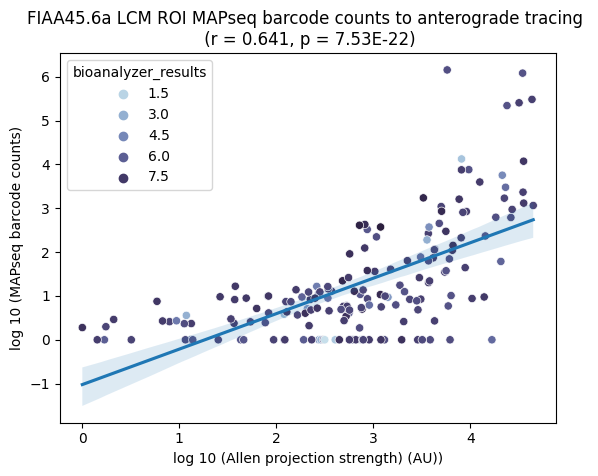

In [64]:
from decimal import Decimal

sb.scatterplot(
    data=FIAA456a_allen_comp,
    x="mean",
    y="MAPseq_counts_numeric",
    hue="bioanalyzer_results",
    palette="ch:s=.25,rot=-.25",
)
sb.regplot(data=FIAA456a_allen_comp, x="mean", y="MAPseq_counts_numeric", scatter=False)
plt.xlabel("log 10 (Allen projection strength) (AU))")
plt.ylabel("log 10 (MAPseq barcode counts)")

corr, p = pearsonr(
    FIAA456a_allen_comp["MAPseq_counts_numeric"], y=FIAA456a_allen_comp["mean"]
)
plt.title(
    f"FIAA45.6a LCM ROI MAPseq barcode counts to anterograde tracing \n (r = {np.round(corr, 3)}, p = {Decimal(p):.2E})"
)

Now do the same for FIAA45.6d

In [65]:
FIAA456d_allen_comp = pd.DataFrame(
    columns=["Sample", "Allen_expt_a", "Allen_expt_b", "Allen_expt_c", "MAPseq_counts"]
)
for tube in filtered_barcodes_A1_source.columns:
    projection_strengths_a = expt_a_normalised[ROI_3D_FIAA456d == tube].sum()
    projection_strengths_b = expt_b_normalised[ROI_3D_FIAA456d == tube].sum()
    projection_strengths_c = expt_c_normalised[ROI_3D_FIAA456d == tube].sum()
    row_data = {
        "Sample": tube,
        "Allen_expt_a": projection_strengths_a,
        "Allen_expt_b": projection_strengths_b,
        "Allen_expt_c": projection_strengths_c,
        "MAPseq_counts": filtered_barcodes_A1_source[tube].sum(),
    }
    FIAA456d_allen_comp = FIAA456d_allen_comp.append(row_data, ignore_index=True)
FIAA456d_allen_comp["mean"] = np.log10(
    FIAA456d_allen_comp[["Allen_expt_a", "Allen_expt_b", "Allen_expt_c"]].mean(axis=1)
    + 1
)
FIAA456d_allen_comp["MAPseq_counts_numeric"] = np.log10(
    pd.to_numeric(FIAA456d_allen_comp["MAPseq_counts"], errors="coerce") + 1
)

/tmp/ipykernel_184374/3639428207.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FIAA456d_allen_comp = FIAA456d_allen_comp.append(row_data, ignore_index=True)
/tmp/ipykernel_184374/3639428207.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FIAA456d_allen_comp = FIAA456d_allen_comp.append(row_data, ignore_index=True)
/tmp/ipykernel_184374/3639428207.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FIAA456d_allen_comp = FIAA456d_allen_comp.append(row_data, ignore_index=True)
/tmp/ipykernel_184374/3639428207.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FIAA456d_allen_comp = FIAA456d_allen_comp.append(row_data, ignore_

In [66]:
RIN_info_FIAA456d = pd.read_csv(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6d/Sequencing/tube_bioanalyzer_FIAA45.6d.csv"
)
FIAA456d_allen_comp = pd.merge(
    FIAA456d_allen_comp,
    RIN_info_FIAA456d,
    left_on="Sample",
    right_on="tube",
    how="left",
)

Text(0.5, 1.0, 'FIAA45.6d LCM ROI MAPseq barcode counts to anterograde tracing \n (r = 0.695, p = 6.81E-28)')

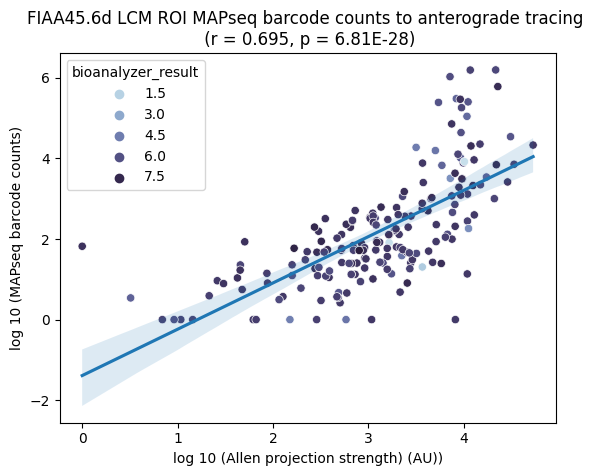

In [67]:
sb.scatterplot(
    data=FIAA456d_allen_comp,
    x="mean",
    y="MAPseq_counts_numeric",
    hue="bioanalyzer_result",
    palette="ch:s=.25,rot=-.25",
)
sb.regplot(data=FIAA456d_allen_comp, x="mean", y="MAPseq_counts_numeric", scatter=False)
plt.xlabel("log 10 (Allen projection strength) (AU))")
plt.ylabel("log 10 (MAPseq barcode counts)")

corr, p = pearsonr(
    FIAA456d_allen_comp["MAPseq_counts_numeric"], y=FIAA456d_allen_comp["mean"]
)
plt.title(
    f"FIAA45.6d LCM ROI MAPseq barcode counts to anterograde tracing \n (r = {np.round(corr, 3)}, p = {Decimal(p):.2E})"
)

For each LCM sample, find the LCM sample in the other brain that most closely matches

In [3]:
ROI_3D_FIAA456a = np.load(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/LCM/ROI_3D_25.npy"
)
ROI_3D_FIAA456d = np.load(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6d/LCM/ROI_3D_25.npy"
)

In [4]:
filtered_soma_FIAA456a = pd.read_pickle("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6a/Sequencing/barcode_matrix_soma_thresholded.pkl"
)
filtered_soma_FIAA456d = pd.read_pickle("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA45.6d/Sequencing/barcode_matrix_soma_thresholded.pkl"
)

In [5]:
#remove ROI for missing tube - temp fix while re-runs
ROI_3D_FIAA456d[ROI_3D_FIAA456d==160] = 0

In [6]:
tubes_FIAA456a = []
centroids_FIAA456a = []
for tube in np.unique(ROI_3D_FIAA456a):
    if tube > 0:
        centroid = np.argwhere(ROI_3D_FIAA456a == tube).mean(axis=0)
        tubes_FIAA456a.append(tube)
        centroids_FIAA456a.append(centroid)

ROI_coords = pd.DataFrame({"Tube": tubes_FIAA456a, "Centroid": centroids_FIAA456a})


tubes = []
centroids = []
for tube in np.unique(ROI_3D_FIAA456d):
    if tube > 0:
        centroid = np.argwhere(ROI_3D_FIAA456d == tube).mean(axis=0)
        tubes.append(tube)
        centroids.append(centroid)

ROI_coords_FIAA456d = pd.DataFrame({"Tube": tubes, "Centroid": centroids})

combinations = [
    (x, y) for x in ROI_coords_FIAA456d["Centroid"] for y in ROI_coords["Centroid"]
]
tube_comp = [(x, y) for x in ROI_coords_FIAA456d["Tube"] for y in ROI_coords["Tube"]]
distances = []
for i in combinations:
    dist = np.linalg.norm(i[0] - i[1])
    distances.append(dist)
tube_A = []
tube_B = []
for i in tube_comp:
    tube_A.append(i[0])
    tube_B.append(i[1])
distances_rois = pd.DataFrame(
    {"Tube A": tube_A, "Tube_B": tube_B, "Distance": distances}
)
df_min_distance = distances_rois.loc[
    distances_rois.groupby("Tube A")["Distance"].idxmin()
]
df_min_distance = pd.concat([df_min_distance, distances_rois.loc[
    distances_rois.groupby("Tube_B")["Distance"].idxmin()
]])
df_min_distance = df_min_distance.drop_duplicates()

In [186]:
# #also find min euclid distance for samples that are not in the min distance for FIAA45.6d samples 
# for tube in filtered_soma_FIAA456a.columns:
#     if tube not in df_min_distance['Tube_B'].to_list():
#         new_row = tube_b_distances[tube_b_distances['Tube_B']==tube]
#         df_min_distance = pd.concat([df_min_distance, new_row])

In [7]:
plt.hist((df_min_distance["Distance"] * 25), color="steelblue", bins=30)
plt.ylabel("Frequency")
plt.xlabel("Euclidean Distance (um)")
plt.title("Distribution of nearest distances between ROIs on different brains")

Text(0.5, 1.0, 'Distribution of nearest distances between ROIs on different brains')

In [7]:
df_min_distance["FIAA456d_counts"] = 0
df_min_distance["FIAA456a_counts"] = 0
for i, r in df_min_distance.iterrows():
    df_min_distance["FIAA456d_counts"].loc[i] = np.log10(filtered_soma_FIAA456d[
        r["Tube A"]
    ].sum() + 1)
    df_min_distance["FIAA456a_counts"].loc[i] = np.log10(filtered_soma_FIAA456a[
        r["Tube_B"]
    ].sum() + 1)

/tmp/ipykernel_131055/1985938329.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_min_distance["FIAA456d_counts"].loc[i] = np.log10(filtered_soma_FIAA456d[
/tmp/ipykernel_131055/1985938329.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_min_distance["FIAA456a_counts"].loc[i] = np.log10(filtered_soma_FIAA456a[


In [8]:
df_min_distance['actual_distance'] = df_min_distance['Distance']*25

Text(0.5, 1.0, 'FIAA45.6a versus FIAA45.6d counts in equivalent samples \n (r = 0.708, p = 1.62E-39)')

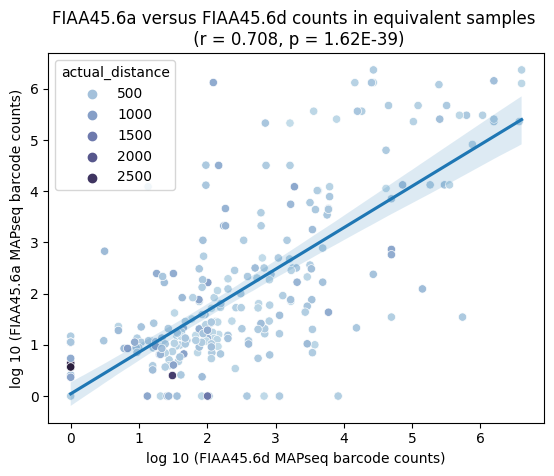

In [214]:
sb.scatterplot(
    data=df_min_distance,
    x="FIAA456d_counts",
    y="FIAA456a_counts", hue= 'actual_distance',
    palette="ch:s=.25,rot=-.25",
)
sb.regplot(data=df_min_distance, x="FIAA456d_counts", y="FIAA456a_counts", scatter=False)
plt.xlabel("log 10 (FIAA45.6d MAPseq barcode counts)")
plt.ylabel("log 10 (FIAA45.6a MAPseq barcode counts)")

corr, p = pearsonr(
    df_min_distance["FIAA456d_counts"], y=df_min_distance["FIAA456a_counts"]
)
plt.title(
    f"FIAA45.6a versus FIAA45.6d counts in equivalent samples \n (r = {np.round(corr, 3)}, p = {Decimal(p):.2E})"
)

In [9]:
df_min_distance['proj_strength_FIAA456d'] = 0
df_min_distance['proj_strength_FIAA456a'] = 0
for i, r in df_min_distance.iterrows():
    df_min_distance["proj_strength_FIAA456d"].loc[i] = np.log10(r["FIAA456d_counts"]/(len(ROI_3D_FIAA456d[ROI_3D_FIAA456d==r["Tube A"]])*25)+1)  
    df_min_distance["proj_strength_FIAA456a"].loc[i] = np.log10(r["FIAA456a_counts"]/(len(ROI_3D_FIAA456a[ROI_3D_FIAA456a==r["Tube_B"]])*25)+1)  

/tmp/ipykernel_131055/3088218329.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_min_distance["proj_strength_FIAA456d"].loc[i] = np.log10(r["FIAA456d_counts"]/(len(ROI_3D_FIAA456d[ROI_3D_FIAA456d==r["Tube A"]])*25)+1)
/tmp/ipykernel_131055/3088218329.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_min_distance["proj_strength_FIAA456a"].loc[i] = np.log10(r["FIAA456a_counts"]/(len(ROI_3D_FIAA456a[ROI_3D_FIAA456a==r["Tube_B"]])*25)+1)


Add annotations

In [10]:
from bg_atlasapi import BrainGlobeAtlas
bg_atlas = BrainGlobeAtlas("allen_mouse_10um", check_latest=False)

In [11]:
#now lets group together the equivalent samples only if within 500um distance
sample_vol_and_regions_FIAA456d =pd.read_pickle(pathlib.Path(FIAA456d_parameters['lcm_directory'])/'sample_vol_and_regions.pkl')
sample_vol_and_regions_FIAA456a =pd.read_pickle(pathlib.Path(FIAA456a_parameters['lcm_directory'])/'sample_vol_and_regions.pkl')


In [12]:
def get_id(id):
    """Function to get acronymn from number id
    Args:
        id(num): id for region name
    Returns:
        acronym(str)
    """
    if id>0:
        if bg_atlas.structures[id]["acronym"][-1].isnumeric():
                id = bg_atlas.structures[id]["structure_id_path"][
                    -2
                ]  # moving one level up the hierarchy if cortical layer
        elif (
            bg_atlas.structures[id]["acronym"][-2:] == "6a"
            or bg_atlas.structures[id]["acronym"][-2:] == "6b"
        ):
            id = bg_atlas.structures[id]["structure_id_path"][
                -2
            ]  # moving one level up the hierarchy if layer 6a/6b
        newid = bg_atlas.structures[id]["acronym"]
        if newid.startswith('IC'): #we don't mind about which bits of IC
            newid= 'IC'
    return newid

In [13]:
reg_names = []
main_region = []
for i, row in sample_vol_and_regions_FIAA456a.iterrows():
    all_regions = sample_vol_and_regions_FIAA456a.loc[i]['Brain Regions']
    all_regions= [i for i in all_regions if i != 0]
    all_reg_converted = []
    for i in all_regions:
        converted = get_id(i)
        all_reg_converted.append(converted)
    regions, counts = np.unique(all_reg_converted, return_counts=True)
    region_counts = pd.DataFrame({'Regions': regions, 'Counts': counts}).sort_values(by='Counts', ascending=False, ignore_index=True)
    first_amount = np.round(region_counts.loc[0]['Counts']/region_counts['Counts'].sum(), 2)
    first_region = region_counts.loc[0]['Regions']
    if len(regions)>1:
        second_region = region_counts.loc[1]['Regions']
        second_amount = np.round(region_counts.loc[1]['Counts']/region_counts['Counts'].sum(), 2)
        breakdown = f'{first_amount} {first_region} & {second_amount} {second_region}'
    else:
        breakdown = f'{first_amount} {first_region}'
    reg_names.append(breakdown)
    main_region.append(first_region)
sample_vol_and_regions_FIAA456a['reg_names'] = reg_names
sample_vol_and_regions_FIAA456a['main_region'] = main_region

In [14]:
reg_names = []
main_region = []
for i, row in sample_vol_and_regions_FIAA456d.iterrows():
    all_regions = sample_vol_and_regions_FIAA456d.loc[i]['Brain Regions']
    all_regions= [i for i in all_regions if i != 0]
    all_reg_converted = []
    for i in all_regions:
        converted = get_id(i)
        all_reg_converted.append(converted)
    regions, counts = np.unique(all_reg_converted, return_counts=True)
    region_counts = pd.DataFrame({'Regions': regions, 'Counts': counts}).sort_values(by='Counts', ascending=False, ignore_index=True)
    first_amount = np.round(region_counts.loc[0]['Counts']/region_counts['Counts'].sum(), 2)
    first_region = region_counts.loc[0]['Regions']
    if len(regions)>1:
        second_region = region_counts.loc[1]['Regions']
        second_amount = np.round(region_counts.loc[1]['Counts']/region_counts['Counts'].sum(), 2)
        breakdown = f'{first_amount} {first_region} & {second_amount} {second_region}'
    else:
        breakdown = f'{first_amount} {first_region}'
    reg_names.append(breakdown)
    main_region.append(first_region)
sample_vol_and_regions_FIAA456d['reg_names'] = reg_names
sample_vol_and_regions_FIAA456d['main_region'] = main_region

Now add these annotations to comparison table

In [15]:
df_min_distance = df_min_distance.reset_index()

In [16]:
Tube_A_reg = []
Tube_B_reg = []
main_the_same = []
main_the_same_inc_second_list = []

for i, r in df_min_distance.iterrows():
    A_reg = sample_vol_and_regions_FIAA456d.loc[sample_vol_and_regions_FIAA456d.index[sample_vol_and_regions_FIAA456d['ROI Number'] == r['Tube A']].tolist()]['reg_names'].item()
    B_reg = sample_vol_and_regions_FIAA456a.loc[sample_vol_and_regions_FIAA456a.index[sample_vol_and_regions_FIAA456a['ROI Number'] == r['Tube_B']].tolist()]['reg_names'].item()
    main_A = sample_vol_and_regions_FIAA456d.loc[sample_vol_and_regions_FIAA456d.index[sample_vol_and_regions_FIAA456d['ROI Number'] == r['Tube A']].tolist()]['main_region'].item()
    main_B = sample_vol_and_regions_FIAA456a.loc[sample_vol_and_regions_FIAA456a.index[sample_vol_and_regions_FIAA456a['ROI Number'] == r['Tube_B']].tolist()]['main_region'].item()
    if main_A==main_B:
        main_comp = True
        main_the_same_inc_second=True
    else:
        main_comp = False
        main_the_same_inc_second=False
    main_the_same.append(main_comp)
    if len(A_reg.split(" ")) ==5:
        second_A = A_reg.split(" ")[4]
        if second_A == main_B:
            main_the_same_inc_second=True
    if len(B_reg.split(" ")) ==5:
        second_B = B_reg.split(" ")[4]
        if second_B == main_A:
            main_the_same_inc_second=True
        if len(A_reg.split(" ")) ==5:
            if second_A == second_B:
                main_the_same_inc_second=True
    Tube_A_reg.append(A_reg)
    Tube_B_reg.append(B_reg)
    main_the_same_inc_second_list.append(main_the_same_inc_second)
df_min_distance['Tube A regions'] = Tube_A_reg
df_min_distance['Tube B regions'] = Tube_B_reg
df_min_distance['Main the same'] = main_the_same
df_min_distance['Main the same inc second'] = main_the_same_inc_second_list

Text(0.5, 1.0, 'Filtered so equivalent samples must have same main region \n(59.8% of samples) (r = 0.73, p = 3.43E-26)')

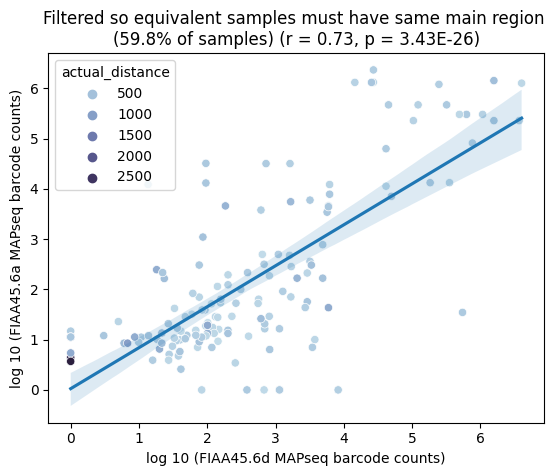

In [223]:
main_filtered = df_min_distance[df_min_distance['Main the same']==True]
sb.scatterplot(
    data=main_filtered,
    x="FIAA456d_counts",
    y="FIAA456a_counts", hue= 'actual_distance',
    palette="ch:s=.25,rot=-.25",
)
sb.regplot(data=main_filtered, x="FIAA456d_counts", y="FIAA456a_counts", scatter=False)
plt.xlabel("log 10 (FIAA45.6d MAPseq barcode counts)")
plt.ylabel("log 10 (FIAA45.6a MAPseq barcode counts)")

corr, p = pearsonr(
    main_filtered["FIAA456d_counts"], y=main_filtered["FIAA456a_counts"]
)
plt.title(
    f"Filtered so equivalent samples must have same main region \n({np.round(len(main_filtered)/len(df_min_distance)*100, 1)}% of samples) (r = {np.round(corr, 3)}, p = {Decimal(p):.2E})"
)


Text(0.5, 1.0, 'Filtered so equivalent samples must have same 1st/2nd main region  \n (87.3% of samples) (r = 0.724, p = 8.35E-37)')

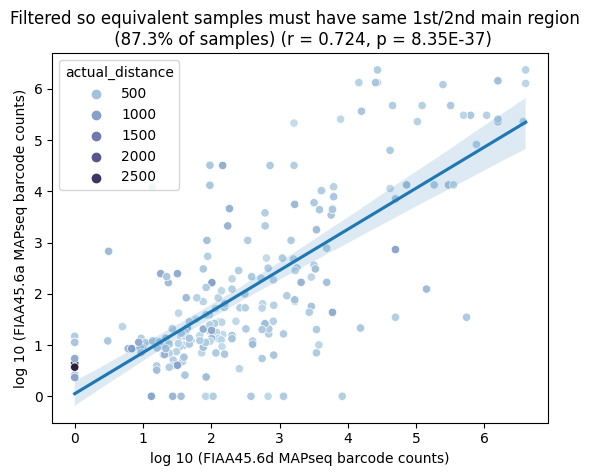

In [224]:
main_filtered = df_min_distance[df_min_distance['Main the same inc second']==True]
sb.scatterplot(
    data=main_filtered,
    x="FIAA456d_counts",
    y="FIAA456a_counts", hue= 'actual_distance',
    palette="ch:s=.25,rot=-.25",
)
sb.regplot(data=main_filtered, x="FIAA456d_counts", y="FIAA456a_counts", scatter=False)
plt.xlabel("log 10 (FIAA45.6d MAPseq barcode counts)")
plt.ylabel("log 10 (FIAA45.6a MAPseq barcode counts)")

corr, p = pearsonr(
    main_filtered["FIAA456d_counts"], y=main_filtered["FIAA456a_counts"]
)
plt.title(
    f"Filtered so equivalent samples must have same 1st/2nd main region  \n ({np.round(len(main_filtered)/len(df_min_distance)*100, 1)}% of samples) (r = {np.round(corr, 3)}, p = {Decimal(p):.2E})"
)


In [17]:
main_filtered = df_min_distance[df_min_distance['Main the same inc second']==True]

In [18]:
tube_to_agg_list = pd.DataFrame()
tube_to_agg_list['Tube A'] = main_filtered['Tube A']
tube_to_agg_list['Tube B'] = main_filtered['Tube_B']
grouped = tube_to_agg_list.groupby('Tube A').agg(list)
grouped2 = tube_to_agg_list.groupby('Tube B').agg(list)

In [19]:
grouped['Tube A agg'] = 0
for i, r in grouped.iterrows():
    mask = grouped2['Tube A'].apply(lambda x: i in x)
    new_df = grouped2[mask]
    flattened_list = [item for sublist in new_df['Tube A'] for item in sublist]
    grouped.loc[i, 'Tube A agg'] = ', '.join(map(str, sorted(np.unique(flattened_list))))
    

In [20]:
grouped2['Tube B agg'] = 0
for i, r in grouped2.iterrows():
    mask = grouped['Tube B'].apply(lambda x: i in x)
    new_df = grouped[mask]
    flattened_list = [item for sublist in new_df['Tube B'] for item in sublist]
    grouped2.loc[i, 'Tube B agg'] = ', '.join(map(str, sorted(np.unique(flattened_list))))
    

In [21]:
grouped2['Tube A_new'] = np.asarray(grouped2['Tube A'])
grouped2['new_B'] = grouped2['Tube B agg'].apply(lambda x: [float(num) for num in x.split(',')])
grouped['new_A'] = grouped['Tube A agg'].apply(lambda x: [float(num) for num in x.split(',')])
grouped['Tube B_new'] = np.asarray(grouped['Tube B'])


In [26]:
# aggregated_samples = pd.DataFrame(columns=['FIAA45.6a', 'FIAA45.6d'])
# for i in np.unique(main_filtered['Tube A']):
#     mask = grouped['new_A'].apply(lambda x: i in x)
#     flattened_list_A = [item for sublist in grouped[mask]['new_A'] for item in sublist]
#     FIAA456d_val = ', '.join(map(str, sorted(np.unique(flattened_list_A)))) 
#     flattened_list = [item for sublist in grouped[mask]['Tube B_new'] for item in sublist]
#     FIAA456a_val = ', '.join(map(str, sorted(np.unique(flattened_list))))
#     new_row = pd.DataFrame({'FIAA45.6a': FIAA456a_val, 'FIAA45.6d': FIAA456d_val}, index=[0])
#     if aggregated_samples.empty:
#             aggregated_samples =pd.concat([aggregated_samples, new_row])
#     bla_6a = aggregated_samples['FIAA45.6a'].apply(lambda x: [float(num) for num in x.split(',')])
#     bla_6d = aggregated_samples['FIAA45.6d'].apply(lambda x: [float(num) for num in x.split(',')])
#     flattened_list_6a = [item for sublist in bla_6a for item in sublist]
#     flattened_list_6d = [item for sublist in bla_6d for item in sublist]
#     already_added = 'no'
#     for it in np.unique(flattened_list_A):
#         if it not in flattened_list_6d:
#             aggregated_samples =pd.concat([aggregated_samples, new_row])
#             already_added = 'yes'
#             break
#     for it in np.unique(flattened_list):
#         if it not in flattened_list_6a and already_added == 'no':
#             aggregated_samples =pd.concat([aggregated_samples, new_row])
#             break
#     already_added = 'no'
#     mask = grouped2['Tube A_new'].apply(lambda x: i in x)
#     flattened_list_A = [item for sublist in grouped2[mask]['Tube A_new'] for item in sublist]
#     FIAA456d_val = ', '.join(map(str, sorted(np.unique(flattened_list_A)))) 
#     flattened_list = [item for sublist in grouped2[mask]['new_B'] for item in sublist]
#     FIAA456a_val = ', '.join(map(str, sorted(np.unique(flattened_list))))
#     new_row = pd.DataFrame({'FIAA45.6a': FIAA456a_val, 'FIAA45.6d': FIAA456d_val}, index=[0])
#     if aggregated_samples.empty:
#             aggregated_samples =pd.concat([aggregated_samples, new_row])
#     bla_6a = aggregated_samples['FIAA45.6a'].apply(lambda x: [float(num) for num in x.split(',')])
#     bla_6d = aggregated_samples['FIAA45.6d'].apply(lambda x: [float(num) for num in x.split(',')])
#     flattened_list_6a = [item for sublist in bla_6a for item in sublist]
#     flattened_list_6d = [item for sublist in bla_6d for item in sublist]
#     already_added = 'no'
#     for it in np.unique(flattened_list_A):
#         if it not in flattened_list_6d:
#             aggregated_samples =pd.concat([aggregated_samples, new_row])
#             already_added = 'yes'
#             break
#     for it in np.unique(flattened_list):
#         if it not in flattened_list_6a and already_added == 'no':
#             aggregated_samples =pd.concat([aggregated_samples, new_row])
#             break
            

In [80]:
aggregated_samples = pd.DataFrame(columns=['FIAA45.6a', 'FIAA45.6d'])
for i in np.unique(main_filtered['Tube A']):
    mask = grouped['new_A'].apply(lambda x: i in x)
    flattened_list_A = [item for sublist in grouped[mask]['new_A'] for item in sublist]
    FIAA456d_val = ', '.join(map(str, sorted(np.unique(flattened_list_A)))) 
    flattened_list = [item for sublist in grouped[mask]['Tube B_new'] for item in sublist]
    FIAA456a_val = ', '.join(map(str, sorted(np.unique(flattened_list))))
    new_row = pd.DataFrame({'FIAA45.6a': FIAA456a_val, 'FIAA45.6d': FIAA456d_val}, index=[0])
    if aggregated_samples.empty:
            aggregated_samples =pd.concat([aggregated_samples, new_row])
    bla_6a = aggregated_samples['FIAA45.6a'].apply(lambda x: [float(num) for num in x.split(',')])
    bla_6d = aggregated_samples['FIAA45.6d'].apply(lambda x: [float(num) for num in x.split(',')])
    flattened_list_6a = [item for sublist in bla_6a for item in sublist]
    flattened_list_6d = [item for sublist in bla_6d for item in sublist]
    already_added = 'no'
    for it in np.unique(flattened_list_A):
        if it not in flattened_list_6d:
            aggregated_samples =pd.concat([aggregated_samples, new_row])
            already_added = 'yes'
            break
    for it in np.unique(flattened_list):
        if it not in flattened_list_6a and already_added == 'no':
            aggregated_samples =pd.concat([aggregated_samples, new_row])
            break
    already_added = 'no'
    mask = grouped2['Tube A_new'].apply(lambda x: i in x)
    flattened_list_A = [item for sublist in grouped2[mask]['Tube A_new'] for item in sublist]
    FIAA456d_val = ', '.join(map(str, sorted(np.unique(flattened_list_A)))) 
    flattened_list = [item for sublist in grouped2[mask]['new_B'] for item in sublist]
    FIAA456a_val = ', '.join(map(str, sorted(np.unique(flattened_list))))
    new_row = pd.DataFrame({'FIAA45.6a': FIAA456a_val, 'FIAA45.6d': FIAA456d_val}, index=[0])
    if aggregated_samples.empty:
            aggregated_samples =pd.concat([aggregated_samples, new_row])
    bla_6a = aggregated_samples['FIAA45.6a'].apply(lambda x: [float(num) for num in x.split(',')])
    bla_6d = aggregated_samples['FIAA45.6d'].apply(lambda x: [float(num) for num in x.split(',')])
    flattened_list_6a = [item for sublist in bla_6a for item in sublist]
    flattened_list_6d = [item for sublist in bla_6d for item in sublist]
    already_added = 'no'
    for it in np.unique(flattened_list_A):
        if it not in flattened_list_6d:
            aggregated_samples =pd.concat([aggregated_samples, new_row])
            already_added = 'yes'
            break
    for it in np.unique(flattened_list):
        if it not in flattened_list_6a and already_added == 'no':
            aggregated_samples =pd.concat([aggregated_samples, new_row])
            break
for i in np.unique(main_filtered['Tube_B']):
    mask = grouped['Tube B_new'].apply(lambda x: i in x)
    flattened_list_A = [item for sublist in grouped[mask]['new_A'] for item in sublist]
    FIAA456d_val = ', '.join(map(str, sorted(np.unique(flattened_list_A)))) 
    flattened_list = [item for sublist in grouped[mask]['Tube B_new'] for item in sublist]
    FIAA456a_val = ', '.join(map(str, sorted(np.unique(flattened_list))))
    new_row = pd.DataFrame({'FIAA45.6a': FIAA456a_val, 'FIAA45.6d': FIAA456d_val}, index=[0])
    if aggregated_samples.empty:
            aggregated_samples =pd.concat([aggregated_samples, new_row])
    bla_6a = aggregated_samples['FIAA45.6a'].apply(lambda x: [float(num) for num in x.split(',')])
    bla_6d = aggregated_samples['FIAA45.6d'].apply(lambda x: [float(num) for num in x.split(',')])
    flattened_list_6a = [item for sublist in bla_6a for item in sublist]
    flattened_list_6d = [item for sublist in bla_6d for item in sublist]
    already_added = 'no'
    for it in np.unique(flattened_list_A):
        if it not in flattened_list_6d:
            aggregated_samples =pd.concat([aggregated_samples, new_row])
            already_added = 'yes'
            break
    for it in np.unique(flattened_list):
        if it not in flattened_list_6a and already_added == 'no':
            aggregated_samples =pd.concat([aggregated_samples, new_row])
            break
    already_added = 'no'
    mask = grouped2['new_B'].apply(lambda x: i in x)
    flattened_list_A = [item for sublist in grouped2[mask]['Tube A_new'] for item in sublist]
    FIAA456d_val = ', '.join(map(str, sorted(np.unique(flattened_list_A)))) 
    flattened_list = [item for sublist in grouped2[mask]['new_B'] for item in sublist]
    FIAA456a_val = ', '.join(map(str, sorted(np.unique(flattened_list))))
    new_row = pd.DataFrame({'FIAA45.6a': FIAA456a_val, 'FIAA45.6d': FIAA456d_val}, index=[0])
    if aggregated_samples.empty:
            aggregated_samples =pd.concat([aggregated_samples, new_row])
    bla_6a = aggregated_samples['FIAA45.6a'].apply(lambda x: [float(num) for num in x.split(',')])
    bla_6d = aggregated_samples['FIAA45.6d'].apply(lambda x: [float(num) for num in x.split(',')])
    flattened_list_6a = [item for sublist in bla_6a for item in sublist]
    flattened_list_6d = [item for sublist in bla_6d for item in sublist]
    already_added = 'no'
    for it in np.unique(flattened_list_A):
        if it not in flattened_list_6d:
            aggregated_samples =pd.concat([aggregated_samples, new_row])
            already_added = 'yes'
            break
    for it in np.unique(flattened_list):
        if it not in flattened_list_6a and already_added == 'no':
            aggregated_samples =pd.concat([aggregated_samples, new_row])
            break
            

Now lets check if there are any duplicate samples in rows

In [82]:
aggregated_samples = aggregated_samples.reset_index(drop=True)

In [83]:

bla_6a = aggregated_samples['FIAA45.6a'].apply(lambda x: [float(num) for num in x.split(',')])
flattened_list_6a = [item for sublist in bla_6a for item in sublist]
dupl = set()
# loop through elements and find matches
for i in flattened_list_6a:
    if flattened_list_6a.count(i) > 1:
        dupl.add(i)


In [84]:
dupl

{38.0, 52.0, 150.0, 158.0, 165.0}

In [85]:
aggregated_samples[aggregated_samples['FIAA45.6a'].str.contains(fr'(?<!\d){38}')]

,FIAA45.6a,FIAA45.6d
14,"38.0, 52.0","23.0, 35.0, 48.0"
22,"38.0, 52.0, 69.0","23.0, 35.0, 48.0"


In [86]:
for i in dupl:
    duplicate_df = aggregated_samples[aggregated_samples['FIAA45.6a'].str.contains(fr'(?<!\d){i}')]
    if len(duplicate_df)>1:
        FIAA456a_dup_values = duplicate_df['FIAA45.6a'].apply(lambda x: [float(num) for num in x.split(',')])
        flattened_FIAA456a=  [item for sublist in FIAA456a_dup_values for item in sublist]
        unique_FIAA456a = ', '.join(map(str, sorted(np.unique(flattened_FIAA456a)))) 
        FIAA456d_dup_values = duplicate_df['FIAA45.6d'].apply(lambda x: [float(num) for num in x.split(',')])
        flattened_FIAA456d=  [item for sublist in FIAA456d_dup_values for item in sublist]
        unique_FIAA456d = ', '.join(map(str, sorted(np.unique(flattened_FIAA456d))))
        new_row = pd.DataFrame({'FIAA45.6a': unique_FIAA456a, 'FIAA45.6d': unique_FIAA456d}, index=[0])
        aggregated_samples = aggregated_samples.drop(index=duplicate_df.index)
        aggregated_samples = pd.concat([aggregated_samples, new_row])
        aggregated_samples = aggregated_samples.reset_index(drop=True)

bla_6d = aggregated_samples['FIAA45.6d'].apply(lambda x: [float(num) for num in x.split(',')])       
flattened_list_6d = [item for sublist in bla_6d for item in sublist]      
dupl_FIAA456d = set()
# loop through elements and find matches
for i in flattened_list_6d:
    if flattened_list_6a.count(i) > 1:
        dupl_FIAA456d.add(i)
for i in dupl_FIAA456d:
    duplicate_df = aggregated_samples[aggregated_samples['FIAA45.6d'].str.contains(fr'(?<!\d){i}')]
    if len(duplicate_df)>1:
        FIAA456a_dup_values = duplicate_df['FIAA45.6a'].apply(lambda x: [float(num) for num in x.split(',')])
        flattened_FIAA456a=  [item for sublist in FIAA456a_dup_values for item in sublist]
        unique_FIAA456a = ', '.join(map(str, sorted(np.unique(flattened_FIAA456a)))) 
        FIAA456d_dup_values = duplicate_df['FIAA45.6d'].apply(lambda x: [float(num) for num in x.split(',')])
        flattened_FIAA456d=  [item for sublist in FIAA456d_dup_values for item in sublist]
        unique_FIAA456d = ', '.join(map(str, sorted(np.unique(flattened_FIAA456d))))
        new_row = pd.DataFrame({'FIAA45.6a': unique_FIAA456a, 'FIAA45.6d': unique_FIAA456d}, index=[0])
        aggregated_samples = aggregated_samples.drop(index=duplicate_df.index)
        aggregated_samples = pd.concat([aggregated_samples, new_row])
        aggregated_samples = aggregated_samples.reset_index(drop=True)

In [93]:
FIAA456a_main_regions = []
FIAA456d_main_regions = []
for ind, row in aggregated_samples.iterrows():
    FIAA456a_list =[]
    for i in range(len(aggregated_samples.loc[ind, 'FIAA45.6a'].split(', '))):
        sample = aggregated_samples.loc[ind, 'FIAA45.6a'].split(', ')[i]
        main_FIAA456a = sample_vol_and_regions_FIAA456a.loc[sample_vol_and_regions_FIAA456a.index[sample_vol_and_regions_FIAA456a['ROI Number'] == float(sample)]]['main_region'].item()
        FIAA456a_list.append(main_FIAA456a)
    FIAA456a_main_regions.append(FIAA456a_list)
    FIAA456d_list =[]
    for i in range(len(aggregated_samples.loc[ind, 'FIAA45.6d'].split(', '))):
        sample = aggregated_samples.loc[ind, 'FIAA45.6d'].split(', ')[i]
        main_FIAA456d = sample_vol_and_regions_FIAA456d.loc[sample_vol_and_regions_FIAA456d.index[sample_vol_and_regions_FIAA456d['ROI Number'] == float(sample)]]['main_region'].item()
        FIAA456d_list.append(main_FIAA456d)
    FIAA456d_main_regions.append(FIAA456d_list)

In [94]:
aggregated_samples['FIAA45.6a_regions'] = FIAA456a_main_regions
aggregated_samples['FIAA45.6d_regions'] = FIAA456d_main_regions


In [102]:
aggregated_samples.to_pickle("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA456a_FIAA456d_aggregation_table.pkl")

In [101]:
aggregated_samples[aggregated_samples['FIAA45.6a_regions'].apply(lambda x: 'AUDp' in x)]

,FIAA45.6a,FIAA45.6d,FIAA45.6a_regions,FIAA45.6d_regions
38,63.0,"59.0, 61.0, 81.0",[AUDp],"[AUDp, AUDp, AUDp]"
51,"83.0, 84.0","82.0, 85.0, 87.0","[AUDp, AUDp]","[AUDp, AUDp, AUDp]"
61,101.0,"99.0, 101.0, 128.0",[AUDp],"[AUDp, AUDp, AUDp]"
62,102.0,100.0,[AUDp],[AUDp]
64,82.0,104.0,[AUDp],[AUDd]
67,109.0,"119.0, 133.0",[AUDp],"[AUDv, TEa]"
68,"90.0, 110.0",120.0,"[AUDp, AUDd]",[AUDp]


In [105]:
ROI_matched_FIAA456a = pd.DataFrame()
ROI_matched_FIAA456d = pd.DataFrame()
for index, row in aggregated_samples.iterrows():
    # Convert sample numbers to floats and sum corresponding columns
    columns_to_combine = []
    for i in range(len(aggregated_samples.loc[index, 'FIAA45.6a'].split(', '))):
        column = float(aggregated_samples.loc[index, 'FIAA45.6a'].split(', ')[i])
        columns_to_combine.append(column)
    ROI_matched_FIAA456a[index] = filtered_soma_FIAA456a[columns_to_combine].sum(axis=1)
    columns_to_combine = []
    for i in range(len(aggregated_samples.loc[index, 'FIAA45.6d'].split(', '))):
        column = float(aggregated_samples.loc[index, 'FIAA45.6d'].split(', ')[i])
        columns_to_combine.append(column)
    ROI_matched_FIAA456d[index] = filtered_soma_FIAA456d[columns_to_combine].sum(axis=1)    

/tmp/ipykernel_131055/2950486799.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ROI_matched_FIAA456a[index] = filtered_soma_FIAA456a[columns_to_combine].sum(axis=1)
/tmp/ipykernel_131055/2950486799.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ROI_matched_FIAA456d[index] = filtered_soma_FIAA456d[columns_to_combine].sum(axis=1)
/tmp/ipykernel_131055/2950486799.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

In [107]:
ROI_matched_FIAA456a.to_pickle("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/ROI_matched_FIAA456a.pkl")

In [108]:
ROI_matched_FIAA456d.to_pickle("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/ROI_matched_FIAA456d.pkl")

In [109]:
FIAA456d_FIAA456a_together = pd.concat([ROI_matched_FIAA456a, ROI_matched_FIAA456d])

In [111]:
FIAA456d_FIAA456a_together = FIAA456d_FIAA456a_together[
    FIAA456d_FIAA456a_together.idxmax(axis=1).isin([64, 62, 61, 51, 38])
]

In [114]:
FIAA456d_FIAA456a_together.to_pickle("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/ROI_matched_FIAA456d_FIAA456a_combined_A1_source.pkl")